# Module 1 - Image Manipulation

To run all but the most basic commands in Python we need to import packages that contain most of the functionality.
Here we will introduce a few that are useful for image manipulation:

1. numpy is a matrix manipulation suite. It is akin to the basic processing package availble in MATLAB. 
2. matplotlib is a graphics toolbox for python. 
3. cv2 is OpenCV, an open-source computer vision library. OpenCV has lots of useful functions to manipulate and analyze images. We will make ample use of the tools in OpenCV

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
import sys

Now all the packages are imported into the workspace. We can now use them inline below. 

First we will grab an image to play with. OpenCV has a really easy routine for it. After, we will display it with plt.

/home/eric/python/pogo_bioobs19_imaging/SPCP2-1515377476-071239-009-36-648-1736-928_rawcolor.jpg


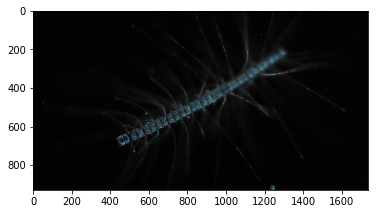

In [2]:
# get the file path of the image in the directory
# glob is a library that impliments pathname pattern expansion in python. os is an operating system navigation package

# this command creates a list of all files with the letters SPC as the first characters in the current working directory. 
ptf = glob.glob(os.path.join(os.getcwd(), 'SPC*'))
print(ptf[0])

# We will grab the first item in the list
img = cv2.imread(ptf[0])

# now display it so we can see what we are working with
plt.imshow(img)

## Image manipulation and transformation

Before getting into the topic of edge detection and region finding, we will practice a few basic image manipulations. Most of these transformations are implemented for us in OpenCV. For now, the routines are mostly being explored to gain some intuition for working with images in Python. But these routines will eventually be useful for *data augmentation* for running deep nets.

First, we will check the data type.
A lot of errors in OpenCV and other image processing libraries occur because of type errors.
The data type is a property of the image and can be accessed with *img.dtype*.

In [3]:
print(img.dtype)

uint8


There are many datatypes that could be useful and images are often convereted from type-to-type depending on the operation being preformed. *uint8* stands for "Unsigned integer" and is in the range of 0 to 255. 0 = black, 255 = white. 

Numpy matrices also make the min and max values easy to access:

In [4]:
# print out the min and max values
print("The max pixel value is: ", str(img.max()))
print("The min pixel value is: ", str(img.min()))

The max pixel value is:  239
The min pixel value is:  0


### Pixels and values
Next, we can start messing with images by referencing particular pixels via their index. Most color images are treated as a 3-D matrix consisting of rows, columns and color chanels. 

The images provided for this tutorial from the Scripps Plankton Camera have three color channels. In OpenCV, images are loaded with colors in BLUE, GREEN, RED order.

To view an image in RGB convert it using cv2.cvtColor.

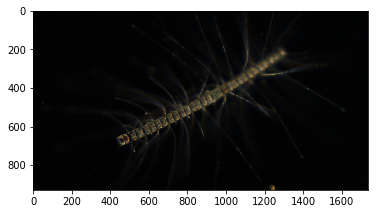

In [23]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

Remember that in Python, indicies are referenced to 0. This is different from R and MATLAB that have all indicies starting at 1.

In [6]:
# Print out the dimensions of the image
img.shape

(928, 1736, 3)

In [7]:
# Retrieve the color values at a particular pixel.
px_val = img[500, 800, :]
print("[B, G, R] values: " + str(px_val))

[B, G, R] values: [65 74 71]


In [8]:
# just look at the RED value
red_val = img[500, 800, 2]
print("The red channel value: " + str(red_val))

The red channel value: 71


Say we want to examine a single color channel from our image 

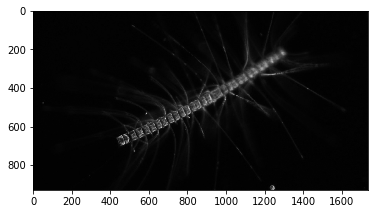

In [9]:
# copy the channel to a new array
img_red = img[:, :, 2]

# now see what it looks like
plt.imshow(img_red, cmap="gray")

Lastly, it is often convenient to convert a color image to gray scale. Again, OpenCV has a built in fuction for that.

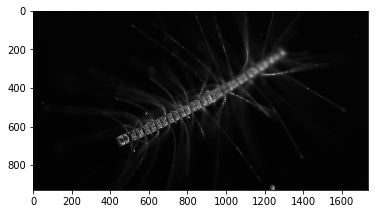

In [10]:
# covert to gray scale with OpenCV
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# give it a look
plt.imshow(img_gray, cmap='gray')

Note that both the *cv2.cvtColor* and *plt.imshow* each used optional arguements. For the gray scale converstion, the optional arguement is telling OpenCV how to interpolate the colors. Likewise, in the figure display, matplotlib needs the appropriate colorscale.

Lastly, sometimes it is useful to select a subsection of an image. This might come in handy for selecting a Region Of Interest from a larger frame or data augmentation

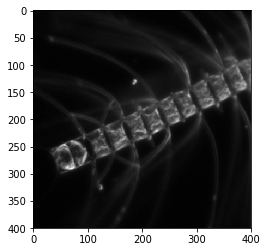

In [11]:
# Select a small chunk of the gray sacle frame
img_sub = img_gray[400:800, 400:800]

# check it out
plt.imshow(img_sub, cmap='gray')

#### Practice
Grab a subregion of the original image with all the color channels. 

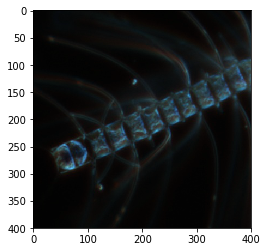

In [12]:
# subregion of color image
clr_sub = img[400:800, 400:800, :]

# plot it
plt.imshow(clr_sub)

Now convert your subregion to gray scale, check the min and max pixel values, and plot it.

The max pixel value is:  193
The min pixel value is:  0


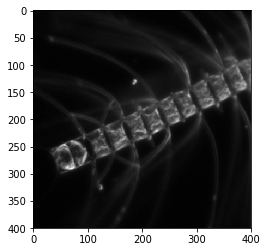

In [13]:
# make your subregion gray scale
clr_sub_gray = cv2.cvtColor(clr_sub, cv2.COLOR_BGR2GRAY)

# print out the min and max values
print("The max pixel value is: ", str(clr_sub_gray.max()))
print("The min pixel value is: ", str(clr_sub_gray.min()))

# plot it
plt.imshow(clr_sub_gray, cmap='gray')

## Transforms
### Resizing
The most common type of transform is resizing. OpenCV has a builtin function to do this: 

In [14]:
# resize the original image to make it half as large

# first save grab the dimensions for use in the function
hh, ww = img.shape[:2]

# then halve the values
new_hh = hh/2
new_ww = ww/2

# print them out
print("The new height will be: ", str(new_hh))
print("The new width will be: ", str(new_ww))

The new height will be:  464.0
The new width will be:  868.0


Notice that these numbers are float (ie decimals). OpenCV requires that indices are integers. We use Python built-in conversion command

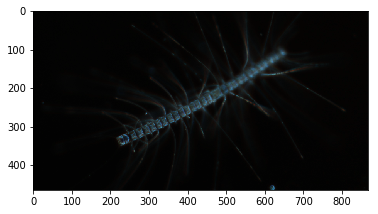

In [15]:
# the second arguement in resize tells it what to do with height
img_resize = cv2.resize(img, (int(ww/2), int(hh/2)))

# plot it
plt.imshow(img_resize)

Be aware that the image resize function **does not** preserve the aspect of the image. This becomes important when running deep nets that require input images to have the same dimensions. After transformation, the input data will not retain aspect information that may be important for classification.

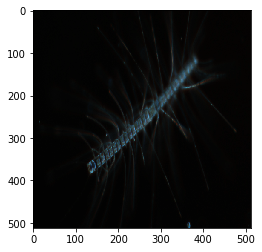

In [16]:
# force the original images to be a square matrix
img_square = cv2.resize(img, (512, 512))

# plot it
plt.imshow(img_square)

The effect may or may not be important depending on your application.

### Image warping
Most transforms in OpenCV are implimented as either an affine or perpective warps. Affine transformations preserve parallelism between the original and modified image -- a set of parallel lines in the original image will remain parallel in the new one. Perpective transforms only preserve straight lines between the original and transformed images.

#### Affine transformations set up
Use these transformations for things like translating, rotating, or shearing the image. All of these transformations require generating a transformation matrix that dictate the mathematical instructions for the warping.   

To translate an image 50 pixels down and 200 pixels to the right

In [17]:
# this is the translation matrix. The desired amount of shift is placed in the final column of the matrix
mm = np.float32([[1, 0, 200], [0, 1, 50]])
print("Translation matrix: ")
print(mm)

Translation matrix: 
[[   1.    0.  200.]
 [   0.    1.   50.]]


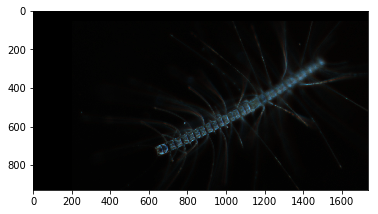

In [18]:
# now do the warping wiht warpAffine()
img_translate = cv2.warpAffine(img, mm, (ww, hh))

# plot it
plt.imshow(img_translate)

Rotating the image about a point requires a different matrix that OpenCV will set up for you with *getRotationMatrix2D*. The first argument defines the point about which to do the rotations. For example, to rotate the image 45 degrees about the center:

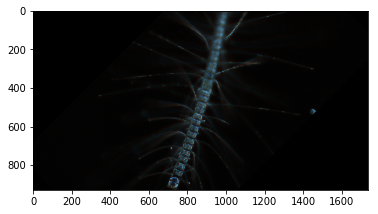

In [19]:
# get the rotation matrix
mm = cv2.getRotationMatrix2D((ww/2, hh/2), 45, 1)

# warp it
img_rot = cv2.warpAffine(img, mm, (ww, hh))

# plot it
plt.imshow(img_rot)

#### Perspective transforms
Perspective warping is good for mimicing the effect of zooming in or out of an image. To produce the behavior, you need to provide *getPerspectiveTransform* with two sets of four points.

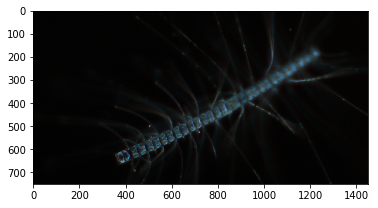

In [20]:
orig_pts = np.float32([[50, 50], [52, 800], [1500, 42], [1550, 750]])
dst_pts = np.float32([[0, 0], [0, 750], [1450, 0], [1450, 750]])

mm = cv2.getPerspectiveTransform(orig_pts, dst_pts)

img_pres = cv2.warpPerspective(img, mm, (1450, 750))

plt.imshow(img_pres)

#### Practice

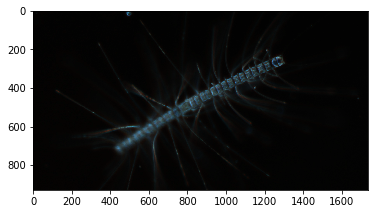

In [21]:
# Flip the test image (rotate it 180 degrees about the middle)
mm = cv2.getRotationMatrix2D((ww/2, hh/2), 180, 1)

# warp it
img_flip = cv2.warpAffine(img, mm, (ww, hh))

# plot it
plt.imshow(img_flip)

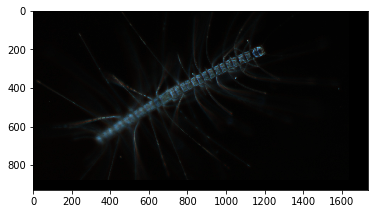

In [22]:
# now translate the rotated image up 50 pixels and 100 to the left
mm = np.float32([[1, 0, -100], [0, 1, -50]])

img_flip_tran = cv2.warpAffine(img_flip, mm, (ww, hh))

# plot it
plt.imshow(img_flip_tran)